## E-matrix estimation on calibrated images of 8 point lights
- Two 3842 x 2878 RGB images by the same camera have been undistorted, and intrinsic matrix is known
- Compute ground truth, by hand-picking correspondences and calling findEssentialMat
- Use Harris corners to find 8 feature points (correspondence candidates)
- Test two iterative methods - Gaussian resampling and recomputing E matrix

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

img1 = cv2.imread('lightsc1.png') # third dimension: colour (BGR)
img2 = cv2.imread('lightsc2.png')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

In [2]:
img2.shape

(2878, 3842, 3)

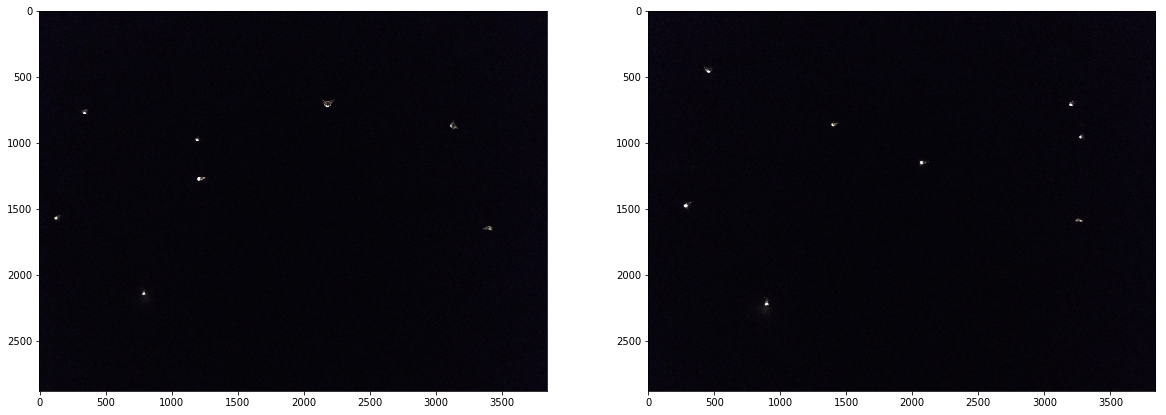

In [3]:
plt.figure(1, figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap = None, interpolation = None) 

plt.subplot(1, 2, 2)
plt.imshow(img2, cmap = None, interpolation = None)

plt.show()

## 1. Compute ground truth from hand-picked correspondences

In [168]:
import numpy as np
import cv2 

# Hand-pick correspondences for ground truth
c1 = np.array([[340. ,  776.],
               [ 124., 1564.],
               [ 792., 2140.],
               [1196.,  976.],
               [1208., 1272.],
               [2180.,  708.],
               [3124.,  872.],
               [3416., 1644.]
              ])

c2 = np.array([[ 456.,  456.],
               [ 288., 1472.],
               [ 896., 2220.],
               [1404.,  860.],
               [2068., 1144.],
               [3200.,  712.],
               [3272.,  960.],
               [3260., 1588.]
              ])

# Normalise image points by multiplying intrinsic matrix inverse
mtx_i = np.array([[ 0.00031822,  0.        , -0.63914398],
                  [ 0.        ,  0.00031683, -0.47034201],
                  [ 0.        ,  0.        ,  1.        ]])

c1_f = np.concatenate((c1, np.ones((c1.shape[0], 1))), axis=1)
c2_f = np.concatenate((c2, np.ones((c1.shape[0], 1))), axis=1)

c1_norm = np.dot(mtx_i, c1_f.T)
c2_norm = np.dot(mtx_i, c2_f.T)
c1_pt = c1_norm[:2].T
c2_pt = c2_norm[:2].T

In [169]:
# Estimate E with normalised points
F, inliers = cv2.findEssentialMat(c2_pt,c1_pt)
print("Inliers:" + str(sum(inliers)[0]) + '/' + str(inliers.shape[0]))
print("F shape: " + str(F.shape))

Inliers:8/8
F shape: (3, 3)


In [170]:
F

array([[ 0.03765123,  0.16675132, -0.07085326],
       [ 0.20760769, -0.03159229, -0.67120094],
       [ 0.06153976,  0.68361521,  0.00543839]])

In [171]:
# Check that X'.T F X = 0 for every correspondence
for i in range(c1_norm.shape[1]):
    print(c1_norm[:,i].T @ F @ c2_norm[:,i])

5.551115123125783e-17
0.00452127023336717
0.004311522835823645
0.0006258740888951952
6.938893903907228e-17
5.551115123125783e-17
4.163336342344337e-17
6.245004513516506e-17


Estimated ground truth from hand-picked coordinates


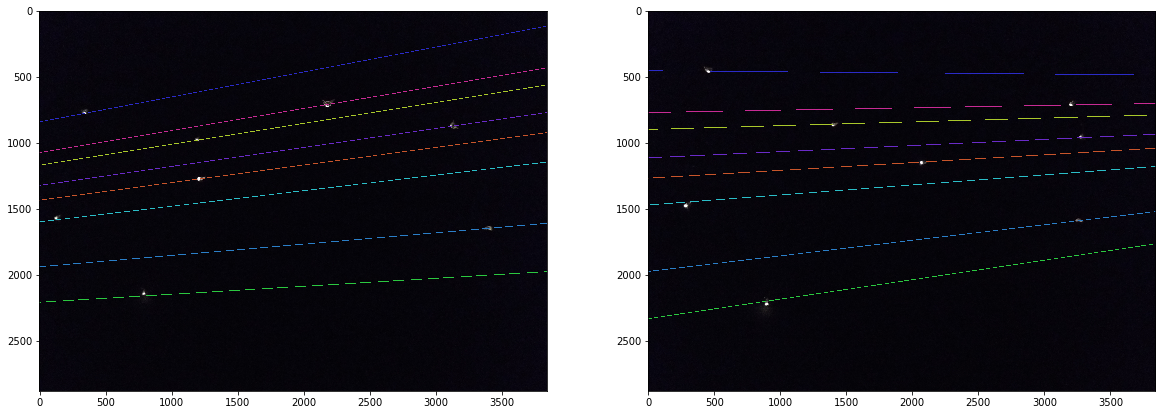

In [173]:
# Drawing epipolar lines

%matplotlib inline
import matplotlib.pyplot as plt

mtx = np.array([[3142.48386708,    0.        , 2008.49963471],
                [   0.        , 3156.22945417, 1484.50729327],
                [   0.        ,    0.        ,    1.        ]])

lines1 = cv2.computeCorrespondEpilines(c2_pt.reshape(-1,1,2), 1, F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,c1.astype(int),c2.astype(int), mtx)

lines2 = cv2.computeCorrespondEpilines(c1_pt.reshape(-1,1,2), 2, F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,c2.astype(int),c1.astype(int), mtx)

print("Estimated ground truth from hand-picked coordinates")
plt.figure(2, figsize=(20,10))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

## 2. Find Harris corners in calibrated images

In [11]:
def img2harris(img, window=13, n_top=200):
    """
    Returns numpy array (num_corners, 2) of top n_top harris corners.

    Parameters
    ----------
    img : BGR image with values in 0-255
        Image returned by call to cv2.imread().
    window : integer
        Image is split into a mosaic of window x window regions. 
        For each region, only the highest corner value is kept.
    n_top: integer
        The remaining corner values are sorted, and the coordinates 
        of the top n_top corners are returned.
    
    """
    
    # convert to gray
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    
    # find harris corners
    dst = cv2.cornerHarris(gray,20,7,0.04) # dst is (rows, cols), not (x, y)
    
    highest = np.zeros_like(dst)
    
    # split into mosaic, keep only highest value per region
    for r in range(0, dst.shape[0], window):
        r_end = min(r + window, dst.shape[0])
        for c in range(0, dst.shape[1], window):
            # define end of window (limited by right edge of image)
            c_end = min(c + window, dst.shape[1])
            
            # write highest value to zeroed matrix
            m = np.max(dst[r:r_end, c:c_end])
            i = np.where(dst[r:r_end, c:c_end] == m)
            
            highest[r:r_end, c:c_end][i] = m
    
    # get top 200 from highest
    ind = np.argpartition(highest, -n_top, None)[-n_top:]
    ind = np.unravel_index(ind, highest.shape)
    
    return ind

In [55]:
# Store Harris corners in ind1, ind2
ind1 = img2harris(img1, 420, n_top=8)
ind2 = img2harris(img2, 420, n_top=8)

img1_disp = img1.copy()
img2_disp = img2.copy()

# Mark corners with red dots
# img1_disp[ind1] = [0,0,255]
# img2_disp[ind2] = [0,0,255]

for pt1 in (np.array(ind1).T):
    img1_disp = cv2.circle(img1_disp,(pt1[1],pt1[0]),20,(255,0,0),-1)

for pt2 in (np.array(ind2).T):
    img2_disp = cv2.circle(img2_disp,(pt2[1],pt2[0]),20,(255,0,0),-1)

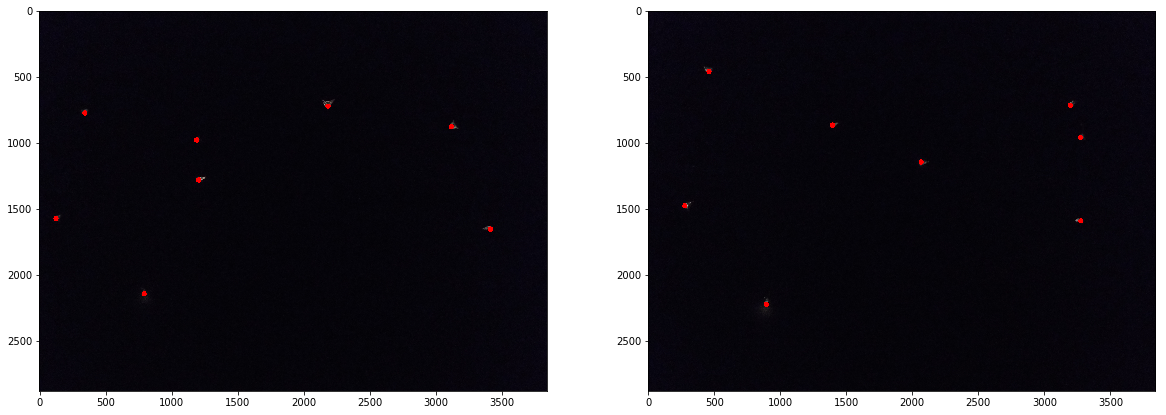

In [56]:
# Display results
plt.figure(1, figsize=(20,10))

plt.subplot(1, 2, 1)
plt.imshow(img1_disp)
# plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(img2_disp)
# plt.xticks([]), plt.yticks([])

plt.show()

In [57]:
# Collect indices of corners (x, y)
c1 = np.array(ind1).T.astype(float)[:,[1,0]]
c2 = np.array(ind2).T.astype(float)[:,[1,0]]
c1

array([[3414., 1652.],
       [ 795., 2141.],
       [3118.,  875.],
       [ 128., 1570.],
       [2185.,  720.],
       [1192.,  977.],
       [1207., 1279.],
       [ 346.,  772.]])

In [58]:
# Normalise the points with intrinsic matrix
from numpy.linalg import inv

K = np.array([[3142.48386708,    0.        , 2008.49963471],
              [   0.        , 3156.22945417, 1484.50729327],
              [   0.        ,    0.        ,    1.        ]])

mtx_i = inv(K)

c1_f = np.concatenate((c1, np.ones((c1.shape[0], 1))), axis=1)
c2_f = np.concatenate((c2, np.ones((c2.shape[0], 1))), axis=1)

c1_norm = np.dot(mtx_i, c1_f.T)
c2_norm = np.dot(mtx_i, c2_f.T)

pts1 = c1_norm[:2].T
pts2 = c2_norm[:2].T

In [62]:
pts1

array([[ 0.44725778,  0.05306734],
       [-0.38615938,  0.20799904],
       [ 0.35306478, -0.19311248],
       [-0.59841187,  0.02708697],
       [ 0.05616588, -0.24222171],
       [-0.2598262 , -0.16079544],
       [-0.2550529 , -0.06511165],
       [-0.52903999, -0.22574635]])

## 3. Test method 1: Gaussian Resampling

In [59]:
import helpers
import numpy as np
from helpers import projectPoints, transformCamera
from math import sin, cos, pi

In [60]:
from importlib import reload
reload(helpers)

<module 'helpers' from 'D:\\Courses\\NUS\\DCVPC\\code\\helpers.py'>

D:\Courses\NUS\DCVPC\code\helpers.py:208: RuntimeWarning: invalid value encountered in less
  all_matches = dists < epsilon


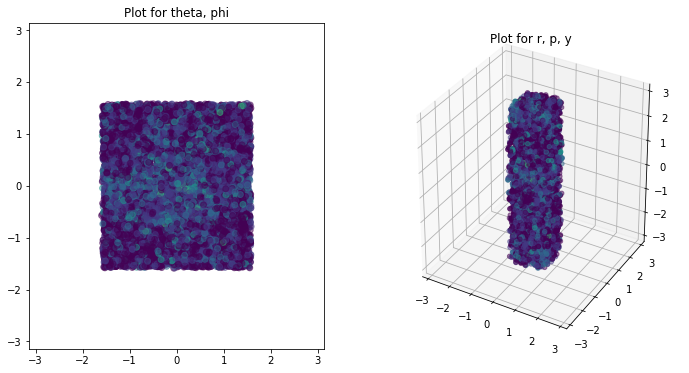

First 200 scores: [2, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0, 3, 1, 1, 1, 0, 1, 2, 1, 3, 0, 1, 1, 0, 3, 1, 0, 2, 1, 0, 2, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 2, 2, 0, 0, 0, 1, 0, 0, 3, 2, 0, 0, 1, 3, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 2, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 2, 4, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 1, 0, 3, 0, 2, 0, 1, 2, 2, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 1, 0, 0, 1, 2, 2, 1, 2, 0, 0, 3, 0, 0, 1, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 3, 1, 3, 2, 1, 0, 0, 1, 0]
Non-match ratio: 0.000000 (0/9841)
Sigma: ['0.010000', '0.010000', '0.010000', '0.010000', '0.010000']
Epsilon: 0.010000
Iteration: 1
Elapsed time: 11.662812s


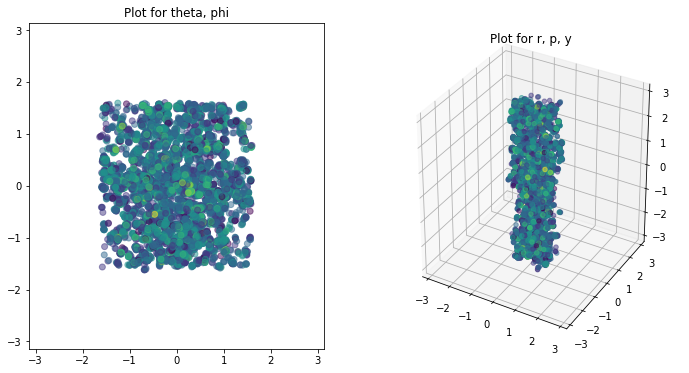

First 200 scores: [3, 2, 4, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 2, 3, 4, 3, 2, 2, 4, 3, 4, 3, 1, 3, 1, 1, 0, 3, 4, 2, 3, 3, 1, 4, 4, 4, 6, 1, 3, 3, 2, 2, 2, 3, 3, 3, 4, 1, 1, 3, 2, 4, 2, 3, 3, 2, 3, 1, 3, 4, 1, 4, 2, 2, 2, 2, 2, 3, 2, 2, 2, 4, 0, 2, 3, 1, 3, 4, 3, 5, 2, 2, 3, 5, 3, 2, 3, 2, 3, 3, 4, 2, 2, 5, 2, 2, 3, 2, 1, 1, 2, 1, 4, 3, 3, 3, 2, 1, 2, 3, 2, 1, 1, 2, 2, 1, 4, 1, 1, 1, 2, 4, 4, 2, 3, 3, 3, 3, 2, 1, 3, 2, 3, 2, 2, 4, 3, 2, 3, 3, 3, 4, 3, 3, 3, 3, 5, 2, 3, 1, 4, 3, 1, 1, 2, 2, 2, 2, 3, 3, 1, 1, 3, 4, 2, 2, 3, 1, 1, 3, 3, 2, 3, 4, 2, 2, 3, 4, 2, 4, 3, 1, 3, 2, 3, 0, 2, 3, 1, 2, 3, 3, 4, 2, 2, 2, 2, 2, 4]
Non-match ratio: 0.000000 (0/29685)
Sigma: ['0.007000', '0.007000', '0.007000', '0.007000', '0.007000']
Epsilon: 0.009000
Iteration: 6
Elapsed time: 64.161294s


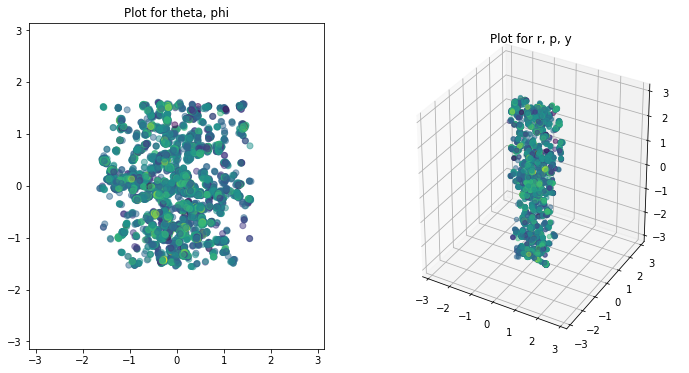

First 200 scores: [4, 4, 4, 2, 4, 1, 2, 2, 2, 4, 2, 4, 4, 3, 4, 2, 4, 4, 4, 4, 3, 2, 3, 2, 4, 4, 5, 4, 1, 5, 3, 4, 3, 2, 3, 3, 0, 2, 3, 2, 3, 3, 5, 4, 4, 2, 3, 3, 3, 3, 3, 4, 5, 3, 4, 3, 2, 3, 4, 4, 3, 5, 3, 2, 4, 2, 3, 3, 2, 2, 2, 2, 5, 3, 2, 4, 1, 3, 5, 3, 3, 4, 2, 1, 4, 3, 2, 4, 3, 3, 2, 3, 3, 3, 3, 3, 4, 3, 1, 1, 4, 2, 4, 2, 3, 4, 5, 5, 2, 4, 4, 2, 2, 3, 2, 2, 1, 4, 3, 3, 2, 3, 2, 4, 2, 1, 4, 2, 4, 4, 3, 4, 3, 4, 4, 3, 2, 2, 2, 3, 1, 3, 4, 3, 2, 4, 3, 4, 2, 4, 2, 2, 2, 5, 3, 4, 4, 3, 4, 4, 2, 5, 4, 5, 4, 2, 2, 4, 3, 3, 2, 6, 3, 3, 2, 4, 2, 4, 3, 3, 3, 1, 5, 5, 5, 4, 4, 3, 3, 3, 1, 2, 3, 3, 4, 3, 4, 4, 2, 4]
Non-match ratio: 0.000000 (0/36348)
Sigma: ['0.004900', '0.004900', '0.004900', '0.004900', '0.004900']
Epsilon: 0.008100
Iteration: 11
Elapsed time: 124.052797s


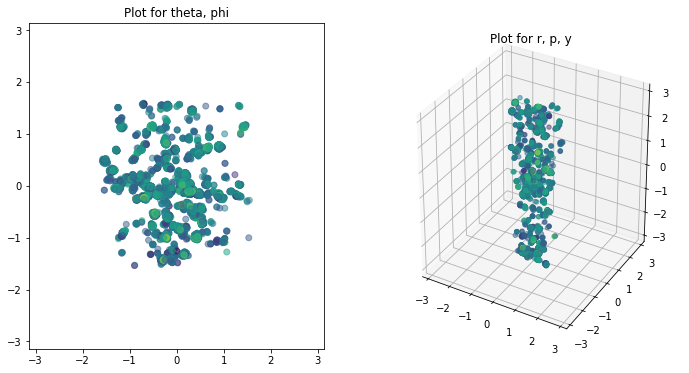

First 200 scores: [4, 5, 6, 3, 3, 3, 5, 2, 1, 5, 4, 3, 5, 3, 4, 4, 3, 4, 4, 3, 5, 1, 2, 3, 4, 2, 5, 4, 2, 3, 3, 3, 5, 4, 5, 3, 5, 2, 3, 3, 4, 6, 2, 3, 4, 3, 3, 4, 4, 3, 3, 2, 2, 4, 3, 2, 4, 3, 4, 3, 3, 5, 3, 3, 3, 3, 4, 3, 1, 4, 4, 4, 6, 4, 5, 5, 6, 0, 3, 4, 4, 3, 5, 3, 4, 3, 1, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 3, 4, 3, 5, 3, 4, 3, 2, 6, 4, 3, 3, 4, 0, 3, 3, 1, 3, 4, 5, 2, 6, 2, 6, 2, 2, 4, 4, 3, 2, 3, 4, 5, 2, 4, 3, 4, 2, 3, 3, 3, 2, 4, 4, 5, 4, 3, 4, 3, 4, 3, 4, 4, 4, 4, 3, 4, 5, 3, 5, 4, 4, 4, 4, 3, 4, 3, 3, 5, 3, 3, 3, 2, 0, 4, 3, 5, 3, 3, 4, 3, 4, 4, 2, 5, 2, 5, 4, 3, 2, 5, 3, 3, 5, 4, 6, 4, 4, 1, 1, 2, 3]
Non-match ratio: 0.000000 (0/42163)
Sigma: ['0.003430', '0.003430', '0.003430', '0.003430', '0.003430']
Epsilon: 0.007290
Iteration: 16
Elapsed time: 180.813162s


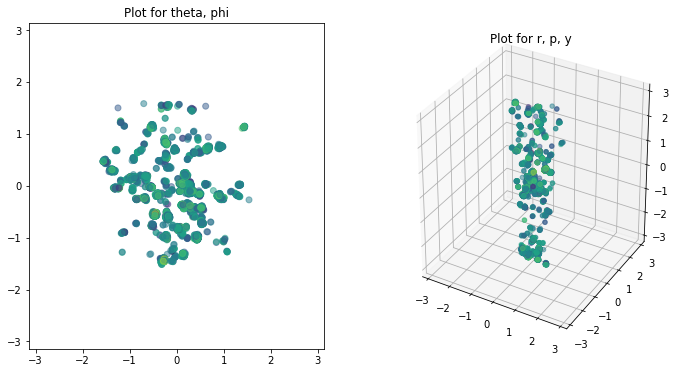

First 200 scores: [6, 2, 3, 2, 3, 4, 4, 4, 5, 5, 4, 4, 5, 5, 5, 5, 5, 4, 5, 4, 4, 5, 4, 6, 3, 4, 3, 6, 5, 6, 5, 2, 5, 4, 2, 2, 5, 4, 4, 6, 5, 4, 2, 3, 4, 4, 4, 5, 5, 1, 3, 5, 4, 3, 5, 5, 4, 2, 4, 5, 4, 6, 4, 4, 4, 4, 5, 4, 3, 5, 5, 5, 2, 5, 4, 2, 6, 6, 5, 5, 4, 4, 4, 4, 2, 5, 5, 3, 5, 4, 5, 5, 3, 5, 5, 5, 5, 6, 3, 6, 3, 5, 4, 3, 2, 4, 4, 4, 5, 6, 4, 5, 5, 4, 4, 3, 6, 5, 6, 4, 6, 3, 4, 5, 4, 3, 2, 5, 5, 4, 6, 3, 5, 1, 5, 4, 2, 5, 4, 5, 4, 4, 3, 4, 4, 6, 1, 5, 4, 5, 4, 4, 4, 5, 3, 4, 4, 6, 5, 4, 4, 5, 2, 4, 5, 4, 5, 5, 4, 5, 6, 5, 4, 4, 3, 3, 4, 4, 5, 5, 4, 4, 5, 4, 3, 5, 2, 5, 5, 4, 4, 3, 4, 5, 3, 5, 5, 5, 4, 5]
Non-match ratio: 0.000000 (0/48962)
Sigma: ['0.003430', '0.003430', '0.003430', '0.003430', '0.003430']
Epsilon: 0.007290
Iteration: 20
Elapsed time: 230.112228s


In [158]:
from helpers import ParticleFilter, generateSamples
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import time

n_corr = 0
start_time = time.time()
# ---------------------------------------------------------
# Adjustable parameters
# ---------------------------------------------------------

iterations = 20
m = 12000

# Set range to be a uniform cube of length 1 around the solution
# ranges = np.array([[*diff_sph-0.5, 1/m], [*diff_sph+0.5, 1/m]]).T  

ranges = np.array([[-pi/2, pi/2],
                   [-pi/2, pi/2],
                   [-pi/4, pi/4],  
                   [-pi/4, pi/4],  
                   [-pi, pi], 
                   [1, 1]])

e = 0.01
sigma = np.array([*[0.01]*5]) 

# Multiply sigma by a factor after a number of iterations
sigma_factor   = 0.7
sigma_interval = 5 

# Multiply epsilon by a factor after a number of iterations
e_factor   = 0.9 #0.5
e_interval = 5

# ---------------------------------------------------------

S_new = generateSamples(m, ranges)

for i in range(iterations):
    S_new, score_list, nmc, mc = ParticleFilter(S_new, sigma, pts1, pts2, n_corr, epsilon = e, epipole_t = 0.1, norm_mode = "softmax")

    # Print for every 5 iterations, and for the last iteration
    if i%5 == 0 or i+1 == iterations: 
        fig = plt.figure(figsize = (18,6))

        ax1 = fig.add_subplot(131)
        ax1.scatter(*S_new[:2,:], c= score_list, alpha=0.5)
        ax1.set_xlim(*[-pi, pi])
        ax1.set_ylim(*[-pi, pi])
        ax1.set_title("Plot for theta, phi")
        
        ax2 = fig.add_subplot(132, projection='3d')
        ax2.scatter(*S_new[2:5,:], c= score_list, alpha=0.5)
        ax2.set_xlim3d(*[-pi, pi])
        ax2.set_ylim3d(*[-pi, pi])
        ax2.set_zlim3d(*[-pi, pi])
        ax2.set_title("Plot for r, p, y")
        
        if S_new.shape[0] == 8:
            ax3 = fig.add_subplot(133)
            ax3.scatter(*S_new[5:7,:], c= score_list, alpha=0.5)
            ax3.set_xlim(*ranges[5])
            ax3.set_ylim(*ranges[6])
            ax3.set_title("Plot for f1, f2")

        plt.show()

        print("First 200 scores: " + str(score_list[:200])) # print first 200 scores only
        print("Non-match ratio: %f (%d/%d)" % (nmc/mc, nmc, mc))
        print("Sigma: " + str(["{0:f}".format(s) for s in sigma]))
        print("Epsilon: %f" % (e))
        print("Iteration: %d" % (i+1))
        print("Elapsed time: %fs" % (time.time() - start_time))
        
    # Decrease sigma over iterations
    if sigma_factor != 1 and (i+1) % sigma_interval == 0:
        sigma *= sigma_factor
    
    # Decrease epsilon over iterations
    if e_factor != 1 and (i+1) % e_interval == 0:
        e *= e_factor

## Recover solution from Particle Filter

In [159]:
# Retrieve highest-scoring points
np.set_printoptions(suppress=True)

n_results = 30
top = S_new[:,S_new[-1,:].argsort()][:, -n_results:].T
print("Max score: " + str(max(S_new[-1])))
top = np.vstack({tuple(row) for row in top})
print(top.shape[0])
print(top)
top = top[:,:-1]

Max score: 7.0
30
[[-0.25855289 -1.42211328 -0.1111928   0.06245652  0.31014198  7.        ]
 [-0.25757347 -1.42740807 -0.11911132  0.05789598  0.30805141  7.        ]
 [-0.26598014 -1.45762106 -0.10483206  0.06285121  0.33594193  7.        ]
 [-0.28004319 -1.44761335 -0.13028724  0.05548488  0.30301731  7.        ]
 [-0.27187998 -1.45951312 -0.11666277  0.06086264  0.33489416  7.        ]
 [-0.27727634 -1.45711717 -0.11787241  0.06251281  0.33353178  7.        ]
 [-0.45743748 -0.54504824  0.27298101  0.32232502  0.41554672  6.        ]
 [-0.27337392 -1.46108654 -0.1243276   0.05904058  0.3337109   7.        ]
 [-0.27503809 -1.45074129 -0.12540931  0.05246647  0.30347596  7.        ]
 [-0.27594636 -1.45612789 -0.11647061  0.06153447  0.33398959  7.        ]
 [-0.27271933 -1.45792971 -0.1065358   0.06444879  0.34022758  7.        ]
 [-0.26927995 -1.42084701 -0.14790529  0.06136317  0.28894094  6.        ]
 [-0.27288696 -1.43099334 -0.12871967  0.05895206  0.31889794  6.        ]
 [-0.27

[[-0.27212092 -1.44396147 -0.12231545  0.06033524  0.32154273]
 [-0.45604558 -0.54801922  0.27713683  0.32249765  0.41187585]]


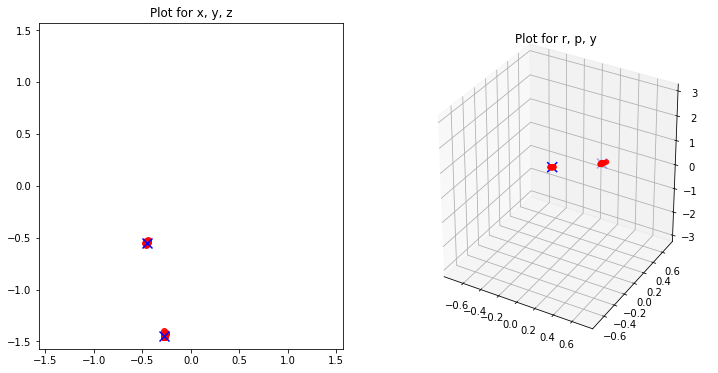

In [162]:
# Retrieve clusters
from sklearn.cluster import KMeans

num_clusters = 2

kmeans_model = KMeans(n_clusters = num_clusters).fit(top)
results = kmeans_model.cluster_centers_
print(results)

res = results.T

fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax1.scatter(*top.T[:2,:], c='red', alpha=0.9)
ax1.scatter(*res[:2,:], c='blue', marker='x', s=100)
ax1.set_xlim(*ranges[0])
ax1.set_ylim(*ranges[1])
ax1.set_title("Plot for x, y, z")

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(*top.T[2:,:m//4], c='red', alpha=0.9)
ax2.scatter(*res[2:,:], zdir='z', c='blue', marker='x', s=100)
ax2.set_xlim3d(*ranges[2])
ax2.set_ylim3d(*ranges[3])
ax2.set_zlim3d(*ranges[4])
ax2.set_title("Plot for r, p, y")
plt.show()

In [163]:
# Construct E from solution t and r, check that (pts1)' E (pts2) = 0

from helpers import rpy2R, xyz2T, sphericalToCartesian
from numpy.linalg import norm
from math import sqrt

pts1_uvf = np.concatenate((pts1, np.ones((pts1.shape[0], 1))), axis = 1)
pts2_uvf = np.concatenate((pts2, np.ones((pts2.shape[0], 1))), axis = 1)

E_results = []
E_products = []

# Compare with ground truth
F_gt = np.array([[ 0.03765123,  0.16675132, -0.07085326],
                 [ 0.20760769, -0.03159229, -0.67120094],
                 [ 0.06153976,  0.68361521,  0.00543839]])

for res_idx in range(results.shape[0]):
    t  = sphericalToCartesian(1, *results[res_idx, :2])
    r  = results[res_idx, 2:]
    
    T = xyz2T(t[0], t[1], t[2])
    R = rpy2R(r[0], r[1], r[2])
    E = np.dot((1/sqrt(2))*T,R)
    print(E)
    print(norm((E if E[0,0] > 0 else -E ) - F_gt))
    print()
    E_results.append(E)
    E_products.append(pts1_uvf @ E @ pts2_uvf.T)

[[-0.04922597 -0.0776225   0.18733413]
 [-0.12928812  0.05123605  0.66717121]
 [-0.09931978 -0.69430374  0.00879792]]
0.17299141891917585

[[-0.21627594 -0.52442997  0.26230114]
 [ 0.39956902  0.01309537  0.5602231 ]
 [-0.22592934 -0.29090922 -0.00685383]]
0.8712398077840537



In [164]:
E_results

[array([[-0.04922597, -0.0776225 ,  0.18733413],
        [-0.12928812,  0.05123605,  0.66717121],
        [-0.09931978, -0.69430374,  0.00879792]]),
 array([[-0.21627594, -0.52442997,  0.26230114],
        [ 0.39956902,  0.01309537,  0.5602231 ],
        [-0.22592934, -0.29090922, -0.00685383]])]

Comparing all n' x n matches


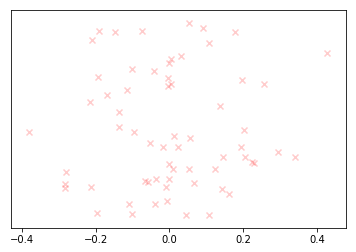

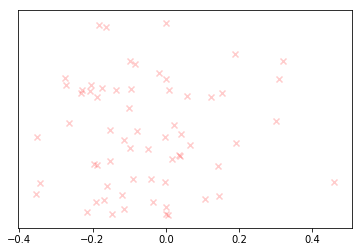

In [165]:
print("Comparing all n' x n matches")
for sol in E_products:
    vals = sol.flatten()
    plt.scatter(vals, np.random.rand(vals.shape[0]), marker='x', color='r', alpha = 0.2)
    plt.yticks([])
    plt.show()

## Plot epipolar lines with E

In [166]:
def drawlines(img1,img2,lines,pts1,pts2,K1):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    rw,c,ch = img1.shape
    
    img1 = img1.copy()
    img2 = img2.copy()
    
    fx = K1[0,0]
    fy = K1[1,1]
    px = K1[0,2]
    py = K1[1,2]
    
    # split colour spectrum 
    n = lines.shape[0]
    col_interval = 255//(n+1)
    
    i = 0
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(cv2.cvtColor(np.uint8([[[col_interval*i, 200, 200]]]), cv2.COLOR_HSV2BGR)[0,0].tolist())

        x0,y0 = map(int, [-fx + px, fy*(-(r[0]*-1 + r[2])/r[1]) + py ])
        x1,y1 = map(int, [ fx + px, fy*(-(r[0]* 1 + r[2])/r[1]) + py ])
        
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 4)
        
        img1 = cv2.circle(img1,(int(round(fx*pt1[0] + px)), int(round(fy*pt1[1] + py))),20,color,-1)
        img2 = cv2.circle(img2,(int(round(fx*pt2[0] + px)), int(round(fy*pt2[1] + py))),20,color,-1)
        
        i += 1
        
    return img1,img2

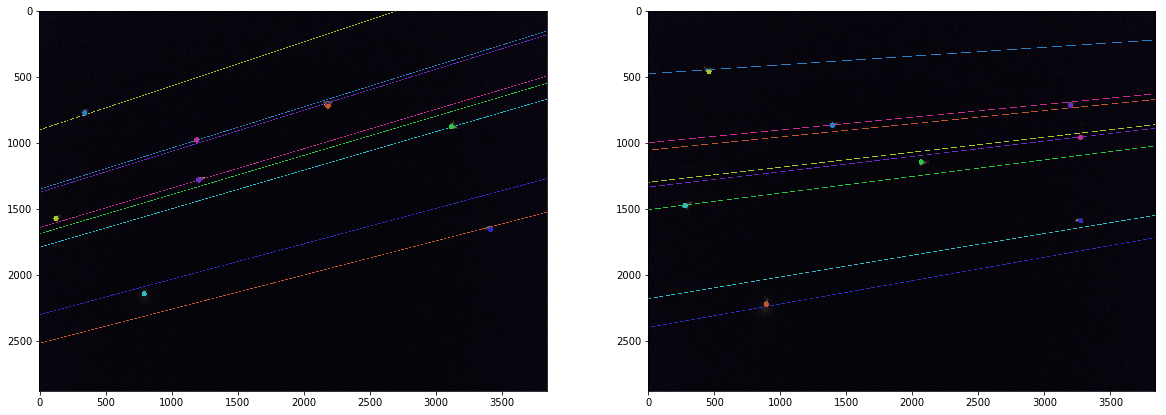

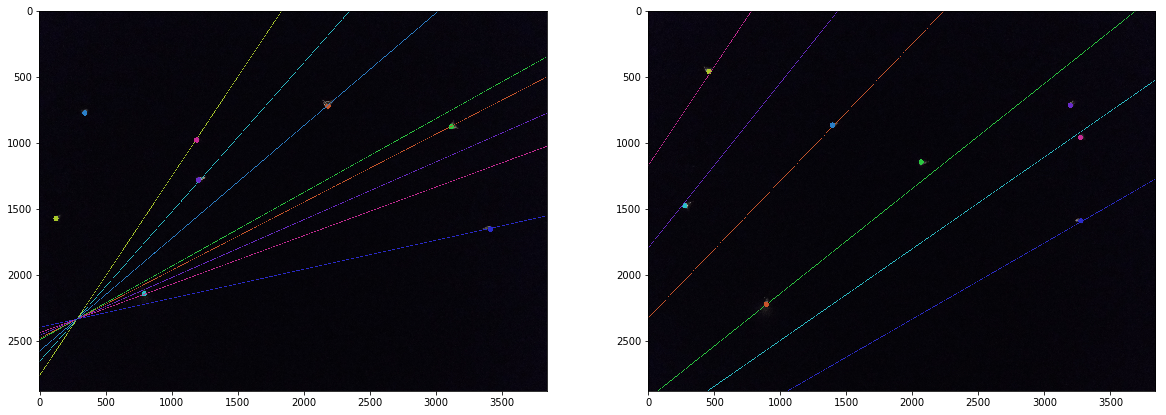

In [167]:
K = np.array([[3142.48386708,    0.        , 2008.49963471],
              [   0.        , 3156.22945417, 1484.50729327],
              [   0.        ,    0.        ,    1.        ]])

for E in E_results:
    # Find epilines corresponding to points (whichImage contains the points, the other image contains lines)

    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 1, E)
    lines1 = lines1.reshape(-1,3)
    img5,img6 = drawlines(img1,img2,lines1,pts1,pts2, K)

    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image

    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 2, E)
    lines2 = lines2.reshape(-1,3)
    img3,img4 = drawlines(img2,img1,lines2,pts2,pts1, K)

    plt.figure(2, figsize=(20,10))
    plt.subplot(121),plt.imshow(img5)
    plt.subplot(122),plt.imshow(img3)
    plt.show()

In [110]:
del img3, img4, img5, img6

## 4. Test method 2: Recomputing E matrix after estimating correspondences


In [111]:
import helpers
from importlib import reload
reload(helpers)

<module 'helpers' from 'D:\\Courses\\NUS\\DCVPC\\code\\helpers.py'>

D:\Courses\NUS\DCVPC\code\helpers.py:208: RuntimeWarning: invalid value encountered in less
  all_matches = dists < epsilon


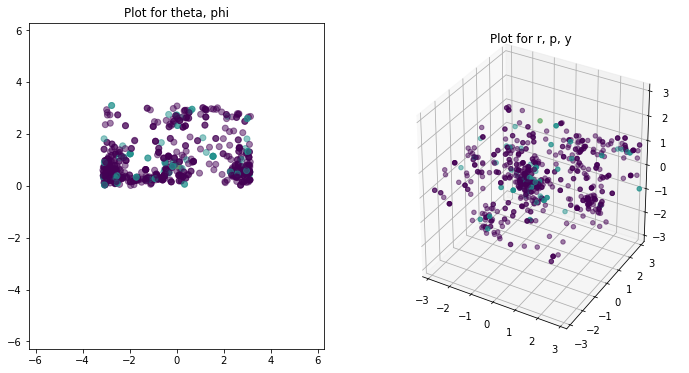

First 200 scores: [5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 6, 5, 6, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Non-match ratio: 0.000000 (0/3823)
Sigma: ['0.080000', '0.080000', '0.080000', '0.080000', '0.080000']
Epsilon: 0.030000
Iteration: 1
Elapsed time: 1399.169083s


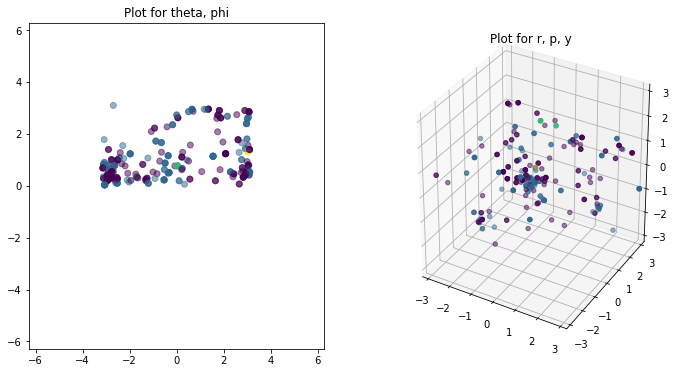

First 200 scores: [5, 5, 5, 6, 5, 6, 5, 6, 6, 5, 6, 6, 5, 6, 8, 6, 5, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 6, 6, 6, 5, 6, 5, 6, 6, 5, 8, 5, 5, 5, 5, 6, 6, 6, 6, 5, 5, 5, 5, 6, 6, 5, 5, 5, 6, 5, 5, 5, 5, 6, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 6, 6, 7, 6, 7, 6, 5, 5, 6, 5, 6, 5, 6, 6, 8, 5, 5, 6, 5, 6, 6, 5, 6, 6, 5, 6, 5, 5, 5, 6, 5, 6, 6, 5, 5, 6, 5, 6, 5, 6, 6, 6, 5, 5, 6, 5, 6, 6, 5, 5, 5, 6, 6, 6, 6, 5, 5, 5, 5, 6, 5, 6, 6, 6, 5, 6, 5, 5, 6, 5, 5, 6, 6, 6, 5, 7, 5, 6, 5, 5, 6, 5, 6, 5, 6, 5, 5, 5, 6, 5, 6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 5, 5, 5, 6, 5, 6, 6, 5, 6, 5, 6, 6, 5, 5, 6]
Non-match ratio: 0.000000 (0/1777)
Sigma: ['0.080000', '0.080000', '0.080000', '0.080000', '0.080000']
Epsilon: 0.024000
Iteration: 2
Elapsed time: 1400.490808s


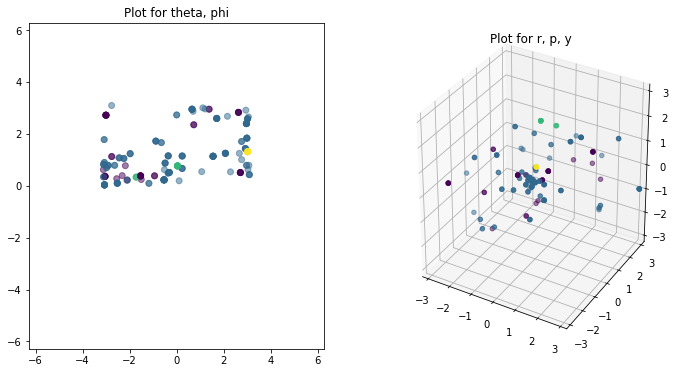

First 200 scores: [5, 6, 6, 5, 5, 6, 6, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 5, 5, 7, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 8, 5, 6, 6, 5, 6, 5, 6, 5, 8, 6, 5, 6, 6, 6, 6, 6, 8, 6, 6, 5, 6, 6, 5, 8, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 5, 7, 5, 6, 6, 6, 6, 6, 6, 6, 6, 5, 8, 5, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 7, 7, 5, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 5, 6, 6, 7, 6, 7, 6, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6, 5, 6, 6, 5, 6, 6, 7, 6, 8, 6, 6, 6, 6, 6, 6, 5, 5, 6, 7, 6, 5, 5, 6, 6]
Non-match ratio: 0.000000 (0/1323)
Sigma: ['0.080000', '0.080000', '0.080000', '0.080000', '0.080000']
Epsilon: 0.019200
Iteration: 3
Elapsed time: 1401.163994s


In [138]:
from helpers import ParticleFilter, generateSamples
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import time
from math import pi

n_corr = 0
start_time = time.time()
# ---------------------------------------------------------
# Adjustable parameters
# ---------------------------------------------------------

iterations = 3
m = 150000

# Set range to be a uniform cube of length 1 around the solution
# ranges = np.array([[*diff_sph-0.5, 1/m], [*diff_sph+0.5, 1/m]]).T  

ranges = np.array([[-pi/2, pi/2],
                   [-pi/2, pi/2],
                   [-pi/4, pi/4], 
                   [-pi/4, pi/4], 
                   [-pi, pi], 
                   [1/m, 1/m]])

e = 0.03
sigma = np.array([*[0.08]*5]) 

# Multiply sigma by a factor after a number of iterations
sigma_factor   = 0.7
sigma_interval = 5 

# Multiply epsilon by a factor after a number of iterations
e_factor   = 0.8 #0.5
e_interval = 1

# ---------------------------------------------------------

S_new = generateSamples(m, ranges)

for i in range(iterations):
    S_new, score_list, nmc, mc = ParticleFilter(S_new, sigma, pts1, pts2, n_corr, epsilon = e, epipole_t = 0.1, 
                                                norm_mode = 'softmax', resampling = "ComputeF")
    
    # Print for every 5 iterations, and for the last iteration
    if i%1 == 0 or i+1 == iterations: 
        fig = plt.figure(figsize = (18,6))

        ax1 = fig.add_subplot(131)
        ax1.scatter(*S_new[:2,:], c= score_list, alpha=0.5)
        ax1.set_xlim(*[-2*pi, 2*pi])
        ax1.set_ylim(*[-2*pi, 2*pi])
        ax1.set_title("Plot for theta, phi")
        
        ax2 = fig.add_subplot(132, projection='3d')
        ax2.scatter(*S_new[2:5,:], c= score_list, alpha=0.5)
        ax2.set_xlim3d(*[-pi, pi])
        ax2.set_ylim3d(*[-pi, pi])
        ax2.set_zlim3d(*[-pi, pi])
        ax2.set_title("Plot for r, p, y")
        
        if S_new.shape[0] == 8:
            ax3 = fig.add_subplot(133)
            ax3.scatter(*S_new[5:7,:], c= score_list, alpha=0.5)
            ax3.set_xlim(*ranges[5])
            ax3.set_ylim(*ranges[6])
            ax3.set_title("Plot for f1, f2")

        plt.show()

        print("First 200 scores: " + str(score_list[:200])) # print first 200 scores only
        print("Non-match ratio: %f (%d/%d)" % (nmc/mc, nmc, mc))
        print("Sigma: " + str(["{0:f}".format(s) for s in sigma]))
        print("Epsilon: %f" % (e))
        print("Iteration: %d" % (i+1))
        print("Elapsed time: %fs" % (time.time() - start_time))
        
    # Decrease sigma over iterations
    if sigma_factor != 1 and (i+1) % sigma_interval == 0:
        sigma *= sigma_factor
    
    # Decrease epsilon over iterations
    if e_factor != 1 and (i+1) % e_interval == 0:
        e *= e_factor

In [143]:
# Retrieve highest-scoring points
np.set_printoptions(suppress=True)
n_results = 10
results = S_new[:,S_new[-1,:].argsort()][:, -n_results:].T
print("Max score: " + str(max(S_new[-1])))
results = np.vstack({tuple(row) for row in results})
print(results)
results = results[:,:-1]

Max score: 8.0
[[ 0.03702713  0.76274976 -0.90168195  2.01712498  1.27281702  7.        ]
 [ 3.01715443  1.31358217  0.01119845  0.06720322  0.55679227  8.        ]
 [-1.72130042  0.33189231 -0.79089032  3.09650189  0.59982353  7.        ]]


In [147]:
# Construct E from solution t and r, check that (pts1)' E (pts2) = 0

from helpers import rpy2R, xyz2T, sphericalToCartesian
from math import sqrt
from numpy.linalg import norm

pts1_uvf = np.concatenate((pts1, np.ones((pts1.shape[0], 1))), axis = 1)
pts2_uvf = np.concatenate((pts2, np.ones((pts2.shape[0], 1))), axis = 1)

E_results2 = []
E_products2 = []

# Compare with ground truth
F_gt = np.array([[ 0.03765123,  0.16675132, -0.07085326],
                 [ 0.20760769, -0.03159229, -0.67120094],
                 [ 0.06153976,  0.68361521,  0.00543839]])

for res_idx in range(results.shape[0]):
    t  = sphericalToCartesian(1, *results[res_idx, :2])
    r  = results[res_idx, 2:]
    
    T = xyz2T(t[0], t[1], t[2])
    R = rpy2R(r[0], r[1], r[2])
    E = np.dot((1/sqrt(2))*T,R)
    print(E)
    print(norm((E if E[0,0] > 0 else -E ) - F_gt))
    print()
    E_results2.append(E)
    E_products2.append(pts1_uvf @ E @ pts2_uvf.T)

[[ 0.10043105  0.48741179  0.11828256]
 [ 0.55979309 -0.02895048 -0.43065819]
 [-0.11572082 -0.46447543 -0.09772891]]
1.2979276055935567

[[-0.04656464 -0.17469441  0.08291054]
 [-0.20589448  0.04305757  0.66973831]
 [-0.07850307 -0.67931598 -0.00325685]]
0.027119051401626904

[[ 0.52092066  0.47325113 -0.0590057 ]
 [ 0.36854506 -0.46157244 -0.3150164 ]
 [ 0.15249791 -0.13282344 -0.11038921]]
1.1634193234452248



Comparing all n' x n matches


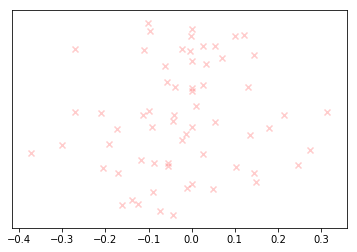

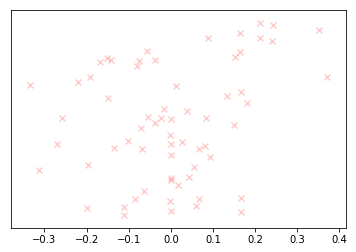

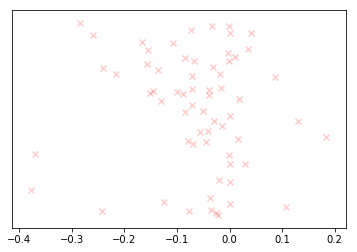

In [145]:
print("Comparing all n' x n matches")
for sol in E_products2:
    vals = sol.flatten()
    plt.scatter(vals, np.random.rand(vals.shape[0]), marker='x', color='r', alpha = 0.2)
    plt.yticks([])
    plt.show()

## Plot epipolar lines with E

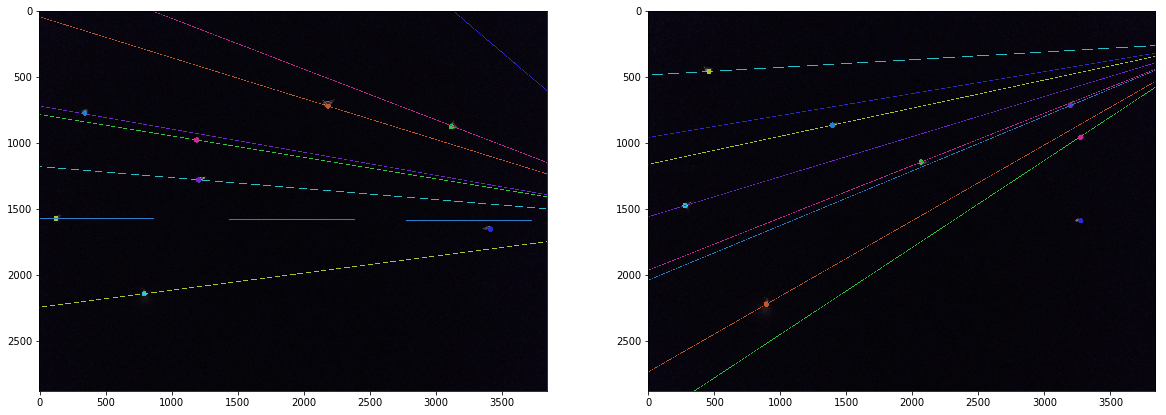

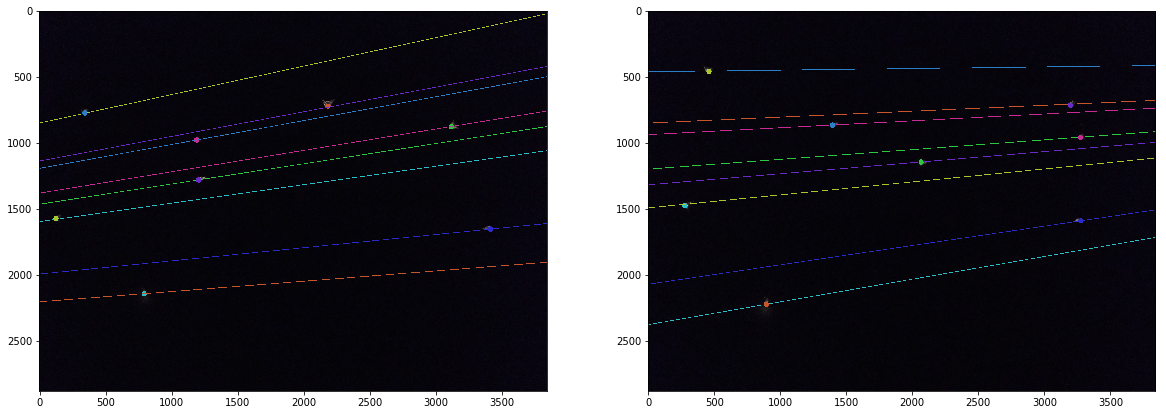

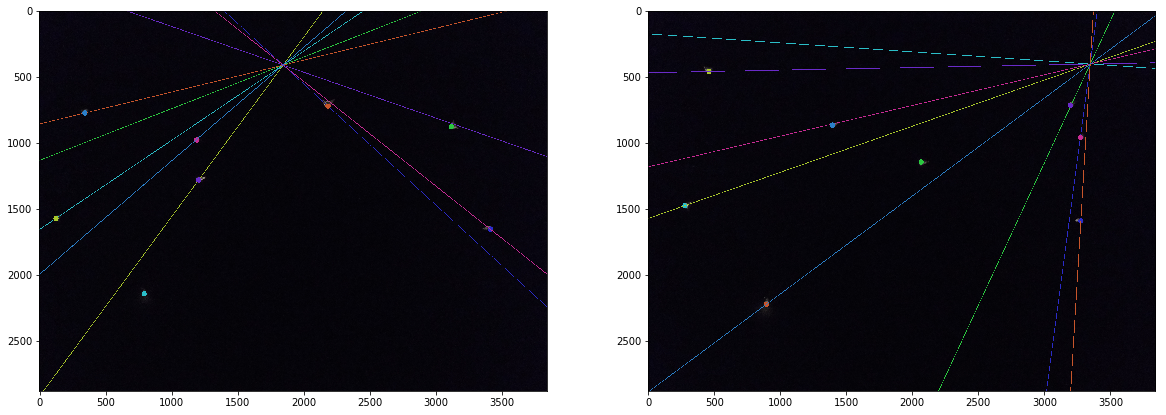

In [146]:
for E in E_results2:
    # Find epilines corresponding to points (whichImage contains the points, the other image contains lines)

    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 1, E)
    lines1 = lines1.reshape(-1,3)
    img5,img6 = drawlines(img1,img2,lines1,pts1,pts2,K)

    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image

    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 2, E)
    lines2 = lines2.reshape(-1,3)
    img3,img4 = drawlines(img2,img1,lines2,pts2,pts1,K)

    plt.figure(2, figsize=(20,10))
    plt.subplot(121),plt.imshow(img5)
    plt.subplot(122),plt.imshow(img3)
    plt.show()